# Context :

## Mental Arithmetic EEG Dataset (36 subjects)

**Source Kaggle + PhysioNet (BIDS format)**

Objectif du dataset
Étudier les modifications de l’activité cérébrale (via EEG) lors de tâches cognitives impliquant une charge mentale élevée (séries de soustractions mentales). Ce dataset est utile pour :

- **la détection de stress cognitif**
- **la classification d'état mental (repos vs activité mentale)**
- les modèles de charge mentale ou de BCI (interfaces cerveau-machine)
- **la génération de connectomes EEG (cohérence, wPLI, etc.)**

## Méthode expérimentale
| Élément                     | Détail                                                                 |
|----------------------------|------------------------------------------------------------------------|
| Nombre de sujets            | 36 (étudiants en biologie / psychologie, âge moyen : 18,6 ans)         |
| Périodes enregistrées       | 3 minutes de repos + 1 minute d’activité mentale                       |
| Tâche cognitive             | Soustraction mentale de 2 nombres (ex : 3141 - 42)                     |
| Environnement               | Chambre sombre insonorisée, yeux fermés pendant l’enregistrement       |
| Position des électrodes     | Norme internationale 10/20  --> positions (Fp1, Fp2, F3, F4, F7, F8, T3, T4, ..., Pz) – 19 canaux au total |
| Matériel EEG                | Neurocom 23-channel system (XAI-MEDICA, Ukraine)                       |
| Fréquence d’échantillonnage | 500 Hz                                                                 |
| Filtrage                    | 0.5–45 Hz + notch 50 Hz + ICA (=Analyse en Composantes Indépendantes -> pour retirer les artéfacts)             |


# Description des fichiers (sur Kaggle)
https://www.kaggle.com/datasets/amananandrai/complete-eeg-dataset#

On dispose de 36 fichiers .csv, chacun correspondant à un sujet, avec :

- Colonnes : 19 canaux EEG standards (Fp1, Fp2, F3, ..., Pz)
- Lignes : ~30 000 points (soit 60 secondes à 500 Hz)


# Groupes de performance mentale
Les 36 sujets sont classés en deux groupes :

- G (Good counters, 24 sujets) : moyenne ≈ 21 opérations
- B (Bad counters, 12 sujets) : moyenne ≈ 7 opérations

Ce classement se trouve dans un fichier participants.tsv dans la version BIDS (PhysioNet), mais il n’est pas présent dans la version Kaggle. Il faudra l’ajouter à la main si nécessaire pour une tâche de classification supervisée.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, welch
import seaborn as sns
import os
import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go

from mne_connectivity import spectral_connectivity_epochs


# Lecture du dataset

In [2]:
csv_path = "../data/dataset/MATH_EEG/s00.csv"

columns = [
    "Fp1", "Fp2", "F3", "F4", "F7", "F8", "T3", "T4",
    "C3", "C4", "T5", "T6", "P3", "P4", "O1", "O2",
    "Fz", "Cz", "Pz"
]

df = pd.read_csv(csv_path, names=columns)

df.head()


,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
0,4.4760,-2.7403,-2.5017,0.095121,-7.0917,-0.42704,-2.5918,-3.3238,0.999500,0.87011,-0.080058,2.8075,-0.52398,1.93410,-3.7614,-1.1440,0.033687,2.7164,0.84831
1,1.2080,-3.3088,-4.4178,-0.529350,-8.5782,0.40699,-3.0996,-3.6005,-0.048363,-0.17258,-0.129650,3.2872,-1.06670,1.53570,-5.1933,-2.2263,-0.682180,4.8287,0.45261
2,-2.5460,-3.7083,-6.4109,-1.003300,-10.2200,1.87700,-3.6952,-3.8673,-1.132300,-1.32850,-0.094006,3.9756,-1.67430,1.12850,-6.5565,-3.0953,-1.284400,6.6513,-0.10393
3,-6.1871,-3.6804,-8.0297,-1.103100,-11.7210,4.01570,-4.2652,-4.0530,-1.984100,-2.36070,0.076473,4.8331,-2.22930,0.79364,-7.4787,-3.4209,-1.540900,7.6371,-0.74250
4,-9.1110,-3.0027,-8.8444,-0.651400,-12.7840,6.71770,-4.6708,-4.0965,-2.337200,-3.02550,0.401930,5.7805,-2.61450,0.58741,-7.6430,-2.9829,-1.248700,7.4512,-1.32640


# On trace les signaux

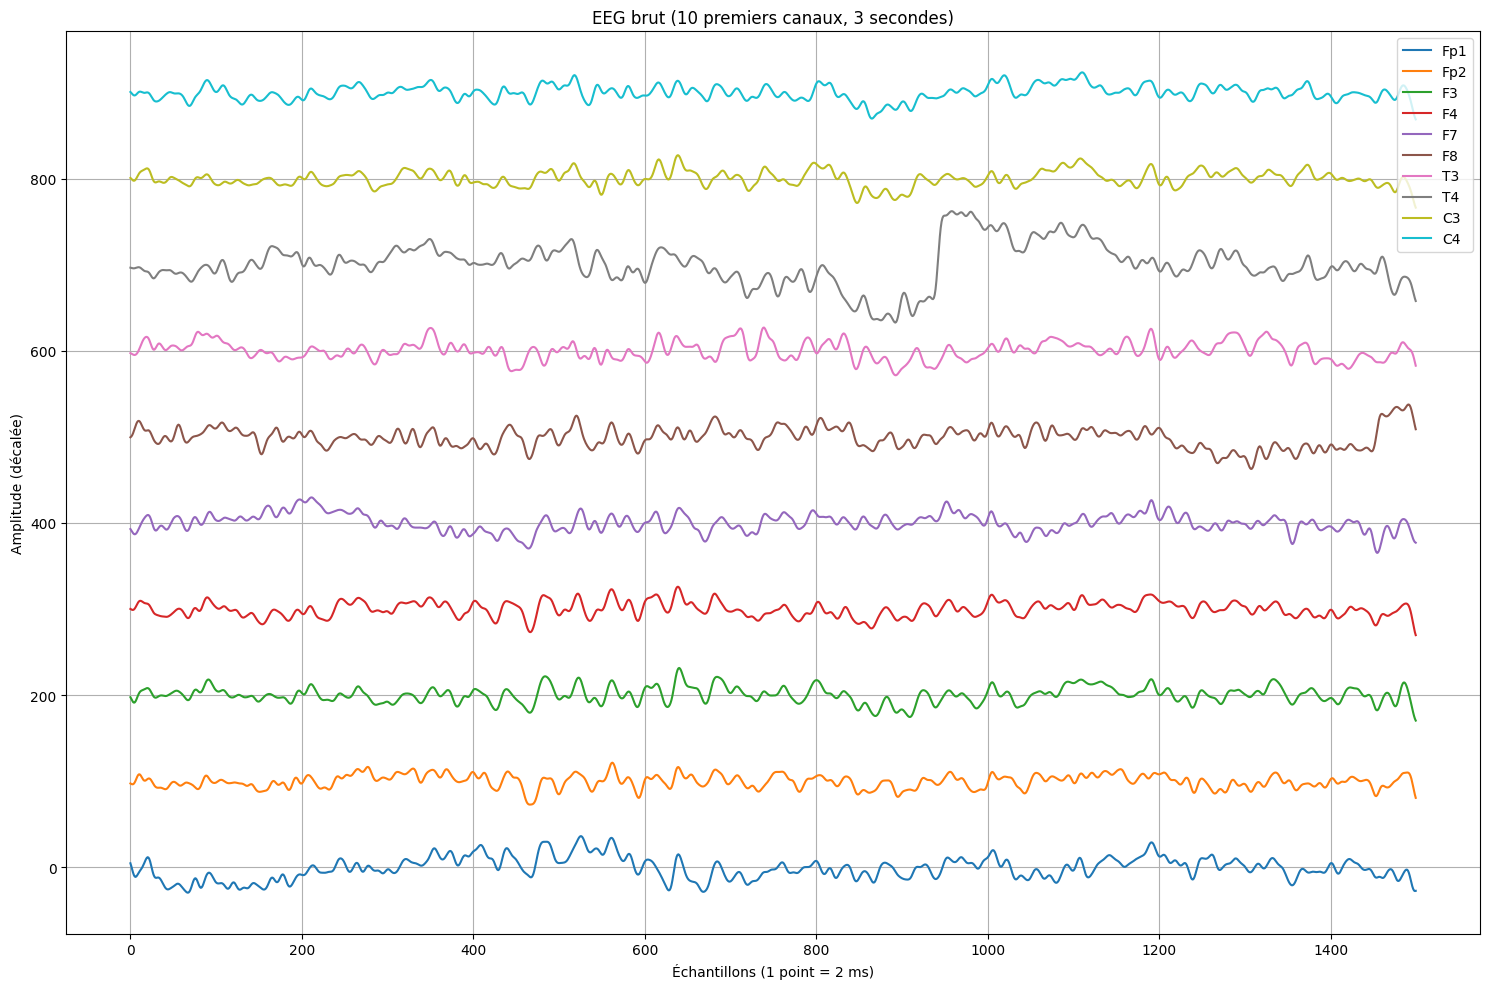

In [3]:
# Paramètres d'affichage
n_seconds = 3
sampling_rate = 500
n_points = n_seconds * sampling_rate

plt.figure(figsize=(15, 10))

# Afficher les 10 premiers canaux
for i, column in enumerate(df.columns[:10]):
    signal = df[column][:n_points]
    plt.plot(signal + i * 100, label=column)  # Décalage vertical pour lisibilité

plt.title(f"EEG brut (10 premiers canaux, {n_seconds} secondes)")
plt.xlabel("Échantillons (1 point = 2 ms)")
plt.ylabel("Amplitude (décalée)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualization d'un canal individuel

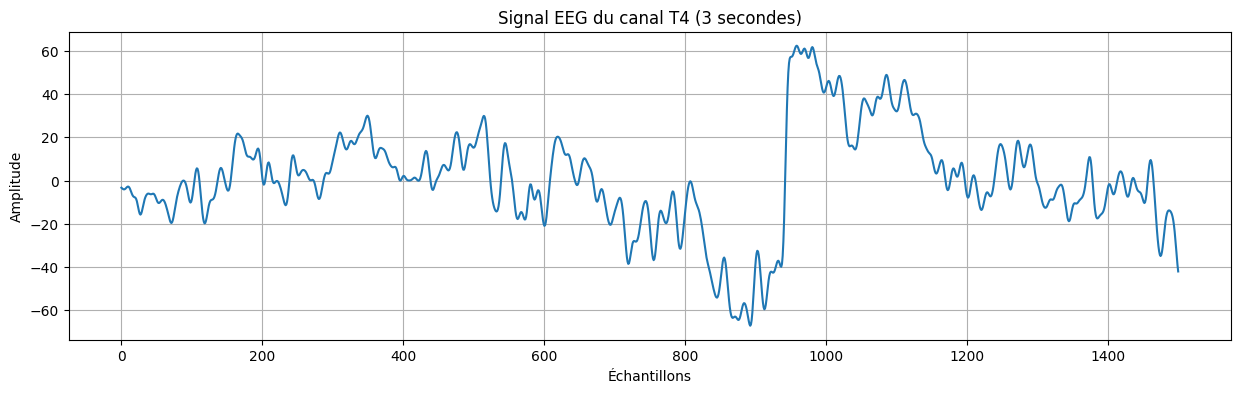

In [4]:
channel = "T4"  
signal = df[channel]

plt.figure(figsize=(15, 4))
plt.plot(signal[:1500])
plt.title(f"Signal EEG du canal {channel} ({n_seconds} secondes)")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# Commençons à voir comment faire un connectome ...
infos utiles : https://connectome-mapper-3.readthedocs.io/en/v3.2.0/api/generated/cmp.pipelines.functional.eeg.html

### Étape 1 : Filtrer nos signaux en bandes de fréquences comme dans l'article : 

| Bande | Plage de fréquence (Hz) | Interprétation                       |
| ----- | ----------------------- | ------------------------------------ |
| Delta | 2 – 4                   | Sommeil profond                      |
| Theta | 4 – 8                   | Sommeil léger, méditation            |
| Alpha | 8 – 12                  | Calme, relaxation                    |
| Beta  | 12 – 30                 | Activité mentale, alerte             |
| Gamma | >= 30                   | Cognition élevée, attention soutenue |
| Theta/Beta | (4-7) / (13-30)    | Marqueur de stress                   |


Dans l'article il parle aussi de alpha haut/bas, beta haut/bas/milieu et le ratio theta/beta ratio.

| Bande | Plage de fréquence (Hz) |
| ----- | ----------------------- | 
| Theta/Beta  | (4-7) / (13-30)   |
| Low Alpha | 8 – 10              |
| High Alpha | 10 – 12            |
| Low Beta | 12 – 18              | 
| Mid Beta | 18 – 21              |
| High Beta | 21 – 30             |
| Low Gamma | 30 – 45             |


--> Filtre passe-bande Butterworth

In [5]:
sampling_rate = 500  # Hz

# ---- Fonction -----
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Applique un filtre passe-bande (Filtre de Butterwhorth) à un signal EEG.

    :param data: Signal EEG brut
    :param lowcut: Fréquence de coupure inférieure (Hz)
    :param highcut: Fréquence de coupure supérieure (Hz)
    :param fs: Fréquence d'échantillonnage (Hz)
    :param order: Ordre du filtre
    :return: Signal EEG filtré
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# ---- Application ----
channel = "T4"
signal = df[channel].values

# ---- Bandes de fréquence souhaitées ----
bands = {
    "Delta": (2, 4),
    "Theta": (4, 8),
    "Low Alpha": (8, 10),
    "High Alpha": (10, 12),
    "Low Beta": (12, 18),
    "Mid Beta": (18, 21),
    "High Beta": (21, 30),
    "Low Gamma": (30, 45),
}


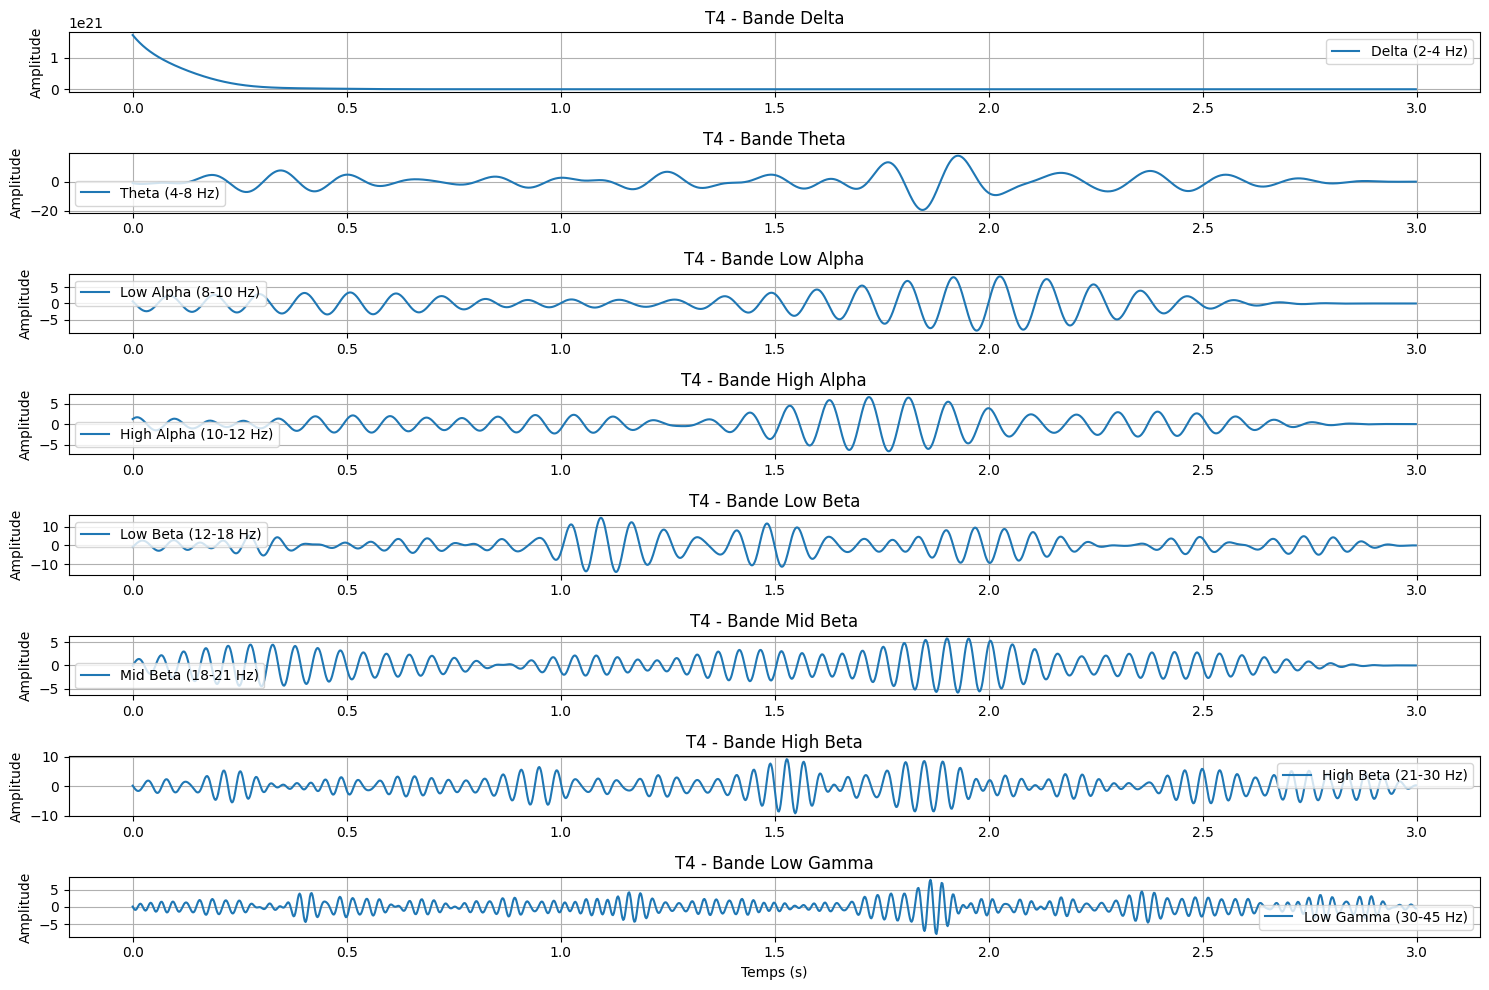

In [6]:
# ---- Visualisation du signal filtré par bande ----
n_seconds = 3
n_samples = n_seconds * sampling_rate
t = np.arange(n_samples) / sampling_rate

plt.figure(figsize=(15, 10))

for i, (band, (low, high)) in enumerate(bands.items()):
    filtered = bandpass_filter(signal[:n_samples], low, high, sampling_rate)
    plt.subplot(len(bands), 1, i + 1)
    plt.plot(t, filtered, label=f'{band} ({low}-{high} Hz)')
    plt.title(f'{channel} - Bande {band}')
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()

plt.xlabel("Temps (s)")
plt.tight_layout()
plt.show()

#### Otention du ratio Theta/Beta

In [7]:
# --- Calcul de la densité spectrale de puissance (PSD) ---
frequencies, psd = welch(signal, fs=sampling_rate, nperseg=n_seconds)
print(frequencies, psd)

[  0.         166.66666667] [0.00279854 0.00567049]


In [8]:
# --- Puissance dans chaque bande ---
def bandpower(frequencies, psd, fmin, fmax):
    freq_mask = (frequencies >= fmin) & (frequencies <= fmax)
    return np.trapz(psd[freq_mask], frequencies[freq_mask])


In [9]:
fmin_theta, fmax_theta = bands["Theta"]
fmin_beta, fmax_beta = (12,30) # Fréquence beta entière

print(fmin_theta, fmax_theta)
print(fmin_beta, fmax_beta)

power_theta = bandpower(frequencies, psd, fmin_theta, fmax_theta)
power_beta = bandpower(frequencies, psd, fmin_beta, fmax_beta)

theta_beta_ratio = power_theta / power_beta

# --- Affichage des résultats ---
print(f"Puissance theta (4-8 Hz) : {power_theta:.4f}")
print(f"Puissance beta (13-30 Hz) : {power_beta:.4f}")
print(f"Ratio theta/beta : {theta_beta_ratio:.4f}")


4 8
12 30
Puissance theta (4-8 Hz) : 0.0000
Puissance beta (13-30 Hz) : 0.0000
Ratio theta/beta : nan


/var/folders/mm/2jz7s_g55bv92cw9dt44jn6c0000gn/T/ipykernel_32541/1740321105.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[freq_mask], frequencies[freq_mask])
/var/folders/mm/2jz7s_g55bv92cw9dt44jn6c0000gn/T/ipykernel_32541/4129548560.py:10: RuntimeWarning: invalid value encountered in scalar divide
  theta_beta_ratio = power_theta / power_beta


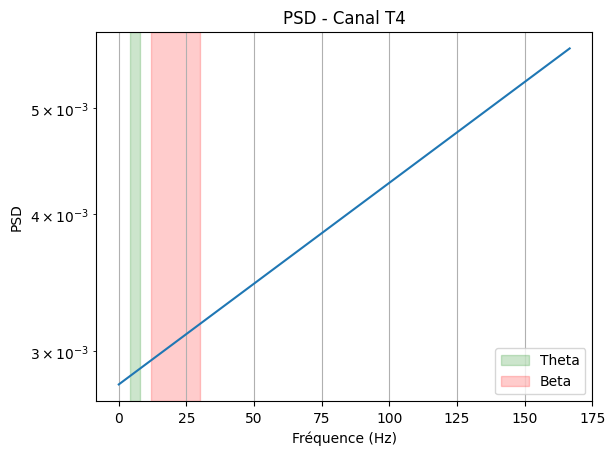

In [10]:
plt.semilogy(frequencies, psd)
plt.axvspan(fmin_theta, fmax_theta, color='green', alpha=0.2, label='Theta')
plt.axvspan(fmin_beta, fmax_beta, color='red', alpha=0.2, label='Beta')
plt.title(f'PSD - Canal {channel}')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

### Étape 2 : Construction des matrice de connectivité

À partir des signaux EEG filtrés dans une bande (ex : alpha), on veut construire une matrice wPLI (via MNE) et une matrice de cohérence.

In [11]:
import numpy as np
from mne_connectivity import spectral_connectivity_epochs

epoch_duration = 10  # secondes
epoch_length = epoch_duration * sampling_rate  # 2500 points
n_channels = len(columns)

# Calcul du nombre total d'époques complètes disponibles
n_total_points = df.shape[0]
n_epochs = n_total_points // epoch_length

# Extraire les données EEG brutes des canaux sélectionnés
data_all = df[columns].values[:n_epochs * epoch_length]  # shape: (n_epochs * epoch_length, n_channels)

# Reshape correctement : (n_epochs, n_channels, n_times)
epoch_data = data_all.reshape(n_epochs, epoch_length, n_channels).transpose(0, 2, 1)  # shape: (n_epochs, n_channels, n_times)

# Calcul de la connectivité wPLI (Gamma)
con = spectral_connectivity_epochs(
    data=epoch_data,
    method="wpli",
    sfreq=sampling_rate,
    fmin=30, fmax=45,  # bande gamma
    faverage=True,
    verbose=True
)

# Extraire la matrice dense finale
connectivity_matrix = con.get_data(output="dense")[:, :, 0]  # shape: (n_channels, n_channels)


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.998s for estimation (5000 points)
    frequencies: 30.0Hz..45.0Hz (151 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]


In [12]:
import networkx as nx
import plotly.graph_objects as go


electrode_positions_10_20 = {
    "Fp1": (-0.5, 1.0),
    "Fp2": (0.5, 1.0),
    "F7": (-1.0, 0.8),
    "F3": (-0.5, 0.7),
    "Fz": (0.0, 0.7),
    "F4": (0.5, 0.7),
    "F8": (1.0, 0.8),
    "T3": (-1.2, 0.4),
    "C3": (-0.5, 0.4),
    "Cz": (0.0, 0.4),
    "C4": (0.5, 0.4),
    "T4": (1.2, 0.4),
    "T5": (-1.0, 0.0),
    "P3": (-0.5, 0.1),
    "Pz": (0.0, 0.1),
    "P4": (0.5, 0.1),
    "T6": (1.0, 0.0),
    "O1": (-0.5, -0.2),
    "O2": (0.5, -0.2)
}

# Créer un graphe non orienté pondéré
G = nx.Graph()
for i, label in enumerate(columns):
    G.add_node(i, label=label)

# Ajouter les arêtes pondérées selon la matrice
threshold = 0.005  # à ajuster selon tes données
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        weight = connectivity_matrix[i, j]
        if weight > threshold:
            G.add_edge(i, j, weight=weight)

# Associer les positions anatomiques aux nœuds
pos = {i: electrode_positions_10_20.get(label, (0, 0)) for i, label in enumerate(columns)}

# Coordonnées des nœuds
node_x = [pos[i][0] for i in G.nodes()]
node_y = [pos[i][1] for i in G.nodes()]
node_labels = [G.nodes[i]['label'] for i in G.nodes()]

# Coordonnées des arêtes
edge_x = []
edge_y = []
edge_weights = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_weights.append(data['weight'] * 5)

# Tracer les arêtes
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=edge_weights, color='gray'),  # couleur fixe
    hoverinfo='none',
    mode='lines'
)

# Tracer les nœuds
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(
        size=20,
        color='skyblue',
        line=dict(width=2, color='darkblue')
    )
)

# Affichage interactif
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Connectome EEG (wPLI - Gamma 30–45 Hz)',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()


ValueError: 
    Invalid value of type 'builtins.list' received for the 'width' property of scatter.line
        Received value: []

    The 'width' property is a number and may be specified as:
      - An int or float in the interval [0, inf]

In [ ]:
print(np.min(connectivity_matrix), np.max(connectivity_matrix))


0.0 0.561293625565572


### Intéressant mais le visuel est bof...

### Attaquons le vrai dataset

In [22]:
csv_path = "../../TD-BRAIN-SAMPLE/derivatives/sub-19684666/ses-1/eeg/sub-19684666_ses-1_task-restEC_eeg.csv"

df = pd.read_csv(csv_path)
columns = df.columns

df.head()
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60003 entries, 0 to 60002
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fp1     60003 non-null  float64
 1   Fp2     60003 non-null  float64
 2   F7      60003 non-null  float64
 3   F3      60003 non-null  float64
 4   Fz      60003 non-null  float64
 5   F4      60003 non-null  float64
 6   F8      60003 non-null  float64
 7   FC3     60003 non-null  float64
 8   FCz     60003 non-null  float64
 9   FC4     60003 non-null  float64
 10  T7      60003 non-null  float64
 11  C3      60003 non-null  float64
 12  Cz      60003 non-null  float64
 13  C4      60003 non-null  float64
 14  T8      60003 non-null  float64
 15  CP3     60003 non-null  float64
 16  CPz     60003 non-null  float64
 17  CP4     60003 non-null  float64
 18  P7      60003 non-null  float64
 19  P3      60003 non-null  float64
 20  Pz      60003 non-null  float64
 21  P4      60003 non-null  float64
 22

In [ ]:
import matplotlib.pyplot as plt

# Exemple : tracer un canal s'il s'appelle 'Fp1' (modifie selon le nom réel)
plt.plot(df['Fp1'][:1000])  # 1000 premiers points
plt.title('Signal EEG - Fp1')
plt.xlabel('Temps (échantillons)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


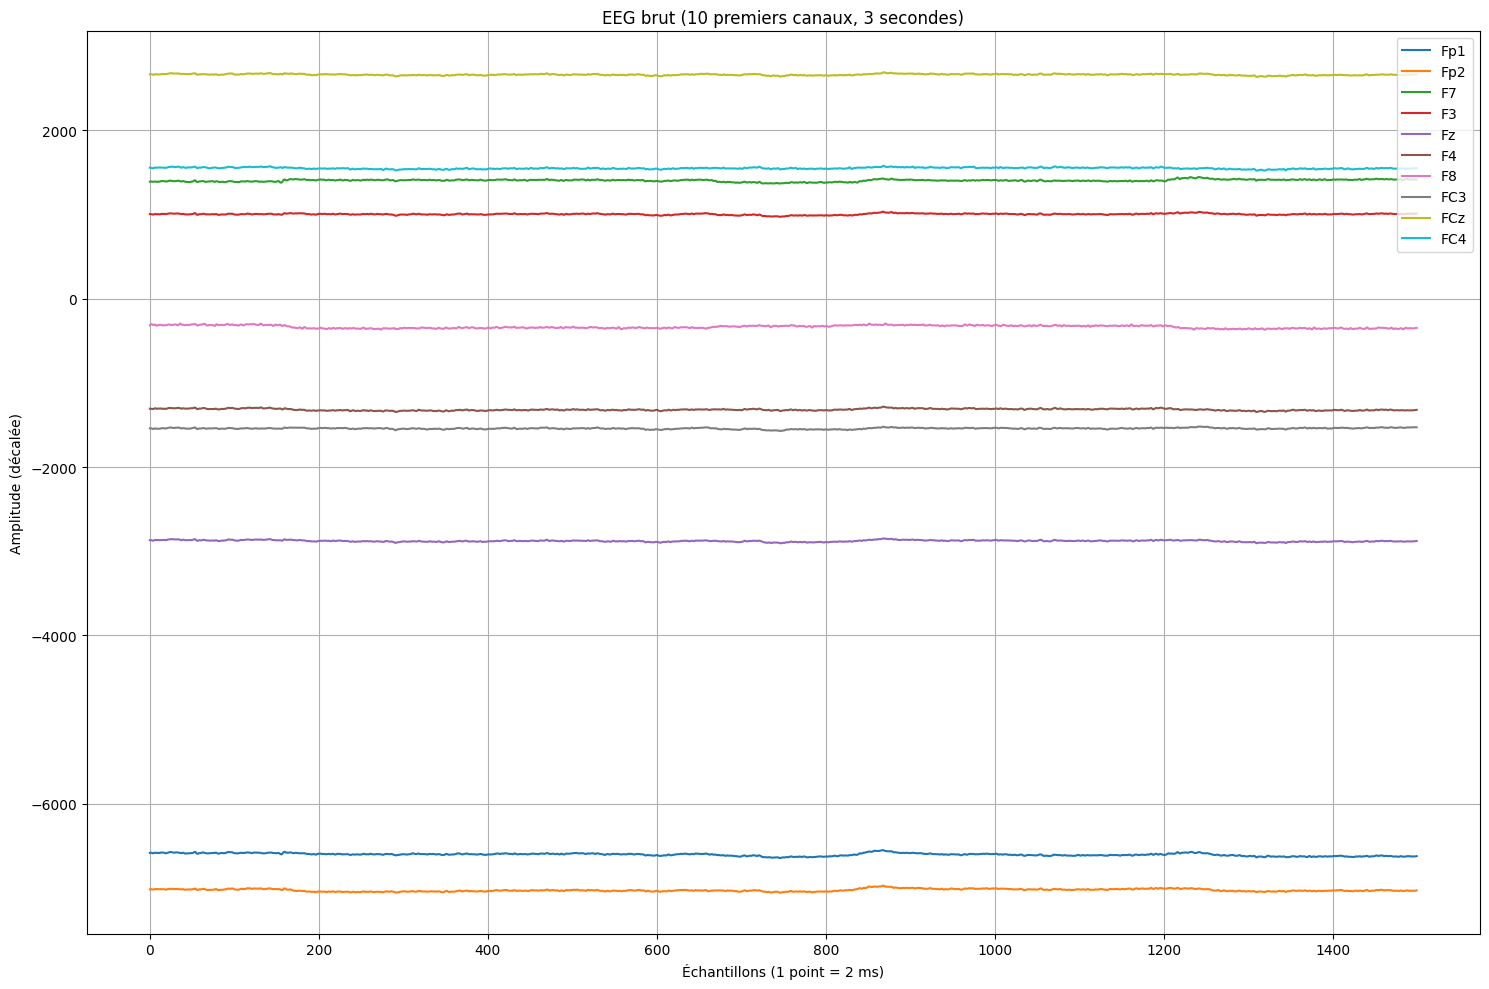

In [29]:
# Paramètres d'affichage
n_seconds = 3
sampling_rate = 500
n_points = n_seconds * sampling_rate

plt.figure(figsize=(15, 10))

# Calcul du décalage vertical basé sur l'écart-type moyen
offset = df.iloc[:n_points, :10].std().mean() * 3

# Afficher les 10 premiers canaux avec décalage
for i, column in enumerate(df.columns[:10]):
    signal = df[column][:n_points]
    plt.plot(signal + i * offset, label=column)

plt.title(f"EEG brut (10 premiers canaux, {n_seconds} secondes)")
plt.xlabel("Échantillons (1 point = 2 ms)")
plt.ylabel("Amplitude (décalée)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Preprocessing